# Analyze A/B Test Results

by Yueh-Han Chen

## Introduction

In this project, I conducted A/B tests and regression analysis to examine the conversion rate difference between the control and experiment groups. 

## Part A
I used 2 approaches, the P-Value method, and Z-tests to conduct A/B Tests.

## Part B
I used regression to examine whether we would get the same conclusion as in Part A.

## Part C
I used multivariate regression to examine whether countries affected conversion rates.

### Let's first assess this dataset.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [25]:
df = pd.read_csv('clean_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
control_converted = df[(df.group == "control") & (df.converted == 1)].shape[0]/df[df.group == "control"].shape[0]

exp_converted = df[(df.group == "treatment") & (df.converted == 1)].shape[0]/df[df.group == "treatment"].shape[0]

In [36]:
control_converted, exp_converted

(0.1203863045004612, 0.11880806551510564)

- Note: Experiment group's convertion rate is 0.15% lower than the control group's.

## Part A-1: A/B Testing with the P-Value method


**Null Hypothesis: P𝑜𝑙𝑑 - P𝑛𝑒𝑤 = 0**

**Alternative Hypothesis: P𝑜𝑙𝑑 - P𝑛𝑒𝑤 != 0**

> P-Value method:

> Step 1: Find the observed difference

> Step 2: Boostrap the sampling distribution to get the standard deviation

> Step 3: Simulate the distribution centered under the null hypothesis

> Step 4: Compute P-Value

> Step 5: Determie the statistical significance of our observed difference

### Step 1: Find the observed difference

In [55]:
obs_diff = control_converted - exp_converted
obs_diff

0.0015782389853555567

### Step 2: Boostrap the sampling distribution to get the standard deviation

In [48]:
sample_diff = []

for i in range(10000):
    sample = df.sample(200, replace=True)
    control = sample.query('group == "control"')
    control_cvr = control.query('converted == 1').shape[0]/control.shape[0]
    exp = sample.query('group == "treatment"')
    exp_cvr = exp.query('converted == 1').shape[0]/exp.shape[0]
    sample_diff.append(control_cvr - exp_cvr)

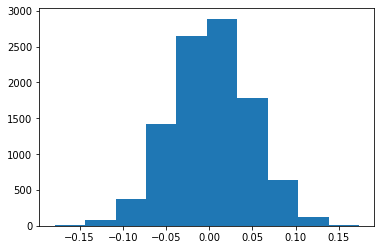

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
    
plt.hist(sample_diff);

In [56]:
std_sampling = np.std(sample_diff)
std_sampling

0.04568971970874579

### Step 3: Simulate the distribution centered under the null hypothesis

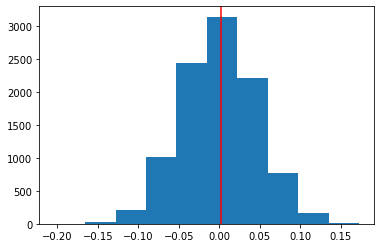

In [52]:
null_vals = np.random.normal(0, std_sampling, len(sample_diff))

plt.hist(null_vals);
plt.axvline(x=obs_diff, color = 'red');

In [60]:
(null_vals > obs_diff).mean() +  (null_vals < (0-obs_diff)).mean() 

0.972

> Conclusion: Since we got P-Value = 0.97, we failed to reject the null hypothesis, meaning that we're confident saying that the control group performed as well as the experiment group, even though we observed that the control group's convertion rate is 0.15% higher than the experiment group's.

## Part A-2: A/B Testing with the Z-test


In [158]:
import statsmodels.api as sm

convert_old = df.query('converted == 1 and landing_page == "old_page"').shape[0]
convert_new = df.query('converted == 1 and landing_page == "new_page"').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [159]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

We have the same null and alternative hypotheses:

**Null Hypothesis: P𝑜𝑙𝑑 - P𝑛𝑒𝑤 = 0**

**Alternative Hypothesis: P𝑜𝑙𝑑 - P𝑛𝑒𝑤 != 0**

In [160]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([convert_old,convert_new])
nobs = np.array([n_old, n_new])

stat, pval = proportions_ztest(count, nobs)

stat, pval

(1.3109241984234394, 0.18988337448195103)

> We got p-value = 0.18, which means that we failed to reject the null hypothesis. We are confident saying that the control group and the experiment group have the similar results.

### Part B - A regression approach

What type of regression should you be performing in this case? **Logistic regression, because logistic regression is appropriate for predicting on binary results.**

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [64]:
import statsmodels.api as sm

df['intercept'] = 1

df[['control', 'treatment']] = pd.get_dummies(df['group'])

LR = sm.Logit(df['converted'], df[['intercept', 'treatment']])

results = LR.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-10-23 14:42 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

> The p-value associated with treatment is 0.18, which means that we failed to rejectt the Null hypothesis

## Extra: Conduct multivariate regression analysis on whether countries affected the conversion rate

In [67]:
df_new = pd.read_csv('countries_data.csv')

In [68]:
df2 = df.join(df_new.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [70]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

LR = sm.Logit(df2['converted'], df2[['intercept', 'treatment', 'CA', 'UK']])

results = LR.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-10-23 14:56 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
treatment    -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

> We found that countries did have statistical significance in affecting conversion rate as CA's p-value is 0.12 and UK's conversion rate is 0.45. 